In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob

In [2]:
ds=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn_grid_vars.nc")

In [3]:
def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut

grid = makeROMSGridObject(ds)

In [4]:
del(ds)

In [5]:
ds=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn_processed.nc")
ds

In [7]:
ds = ds[['u','v','w','dz','dx','dy','temp','salt']]
ds.load()

<xarray.Dataset>
Dimensions:     (ocean_time: 73, s_rho: 31, eta_rho: 600, xi_u: 799,
                 eta_v: 599, xi_rho: 800, s_w: 32)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2025-12-30 2026-01-04 ... 2026-12-25
  * s_rho       (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w         (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    lat_rho     (eta_rho, xi_rho) float64 -30.0 -30.0 -30.0 ... -24.01 -24.01
    lon_rho     (eta_rho, xi_rho) float64 151.5 151.5 151.5 ... 159.5 159.5
    z_w         (ocean_time, s_w, eta_rho, xi_rho) float64 0.0 0.0 ... -0.008157
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -0.2681
    z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -0.8484 -0.2858
Dimensions without coordinates: eta_rho, xi_u, eta_v, xi_rho
Data variables:
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 nan nan ... -0.1506
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 nan nan ... -0.06594
    w           (ocean_time, s_w, eta_rho, xi_rho) float32 nan ... -1.179e-06
    dz          (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... 0.5342
    dx          (eta_rho, xi_rho) float64 963.0 963.0 ... 1.016e+03 1.016e+03
    dy          (eta_rho, xi_rho) float64 1.112e+03 1.112e+03 ... 1.112e+03
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 nan nan ... 24.87
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 nan nan ... 35.52
Attributes: (12/38)
    CDI:                        Climate Data Interface version 2.0.4 (https:/...
    Conventions:                CF-1.4, SGRID-0.3
    file:                       roms_his_0020.nc
    format:                     netCDF-3 64bit offset file
    type:                       ROMS grid file
    title:                      South-east Queensland, 1/100 (900m) degree re...
    ...                         ...
    history:                    Mon Feb 19 09:22:01 2024: ncks -A ROMS_grid_c...
    ana_file:                   ROMS/Functionals/ana_btflux.h
    CPP_options:                SEQLD, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE,...
    CDO:                        Climate Data Operators version 2.0.4 (https:/...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    history_of_appended_files:  Mon Feb 19 09:22:01 2024: Appended file ROMS_...

In [8]:
def calc_KmKe(input):

    u = input.u
    v = input.v

    u_bar = u.mean("ocean_time")
    v_bar = v.mean("ocean_time")

    # input.u_bar.attrs["grid"] = grid
    # input.v_bar.attrs["grid"] = grid

    # mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u - u_bar
    v_prime = v - v_bar
    del(u)
    del(v)

    u_bar_rho=grid.interp(u_bar,axis="X",boundary="fill")
    v_bar_rho=grid.interp(v_bar,axis="Y",boundary="fill")

    u_prime_rho=grid.interp(u_prime,axis="X",boundary="fill")
    del(u_prime)
    v_prime_rho=grid.interp(v_prime,axis="Y",boundary="fill")
    del(v_prime)


    
    dudx = grid.derivative(u_bar,'X',boundary='fill')
    del(u_bar)
    dudy = grid.derivative(u_bar_rho,'Y',boundary='fill')
    dvdx = grid.derivative(v_bar_rho,'X',boundary='fill')
    dvdy = grid.derivative(v_bar,'Y',boundary='fill')
    del(v_bar)

    dudy = grid.interp(dudy,axis="Y",boundary="fill")
    dvdx = grid.interp(dvdx,axis="X",boundary="fill")

    rho0 = 1025

    uu = (u_prime_rho*u_prime_rho).mean(dim='ocean_time')
    uv = (u_prime_rho*v_prime_rho).mean(dim='ocean_time')
    vu = (v_prime_rho*u_prime_rho).mean(dim='ocean_time')
    vv = (v_prime_rho*v_prime_rho).mean(dim='ocean_time')


    KmKe = -rho0*(uu*dudx + uv*dudy + vu*dvdx + vv*dvdy)
    del(uu)
    del(uv)
    del(vu)
    del(vv)
    del(dudy)
    del(dvdx)
    del(dudx)
    del(dvdy)
    del(u_bar_rho)
    del(v_bar_rho)
    return KmKe

In [9]:
ds_kmke = calc_KmKe(ds)
ds['kmke'] = ds_kmke
del(ds_kmke)

In [10]:
weights = (ds.dx*ds.dy*ds.dz).mean(dim='ocean_time')
weights.name = "weights"
mask = ds.z_rho0>-450

ds["_kmke450"] = ds.kmke.where(mask).weighted(weights).mean(dim='s_rho')

In [11]:
def rho_eos(Tt,Ts,z_r):
    #     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # %
    # % function [rho,bvf]=rho_eos(Tt,Ts,z_r)
    # %
    # % Computes density via Equation Of State (EOS) for seawater.
    # % If so prescribed, non-linear EOS of Jackett and McDougall (1995)
    # % is used.
    # %
    # % Tt potential temperature [deg Celsius].
    # % Ts salinity [PSU].
    # % Tz pressure/depth, [depth in meters and negative].
    # %
    # % K0, K1 and K2 are the pressure polynomial coefficients for secant
    # % bulk modulus, so that
    # %
    # %               bulk = K0 - K1 * z + K2 * z**2 ;
    # %
    # % while rho1 is sea-water density [kg/m^3] at standard pressure
    # % of 1 Atm, so that the density anomaly at in-sity pressure is
    # %
    # %               rho = rho1 / (1 + z / bulk) - 1000
    # %
    # %  Reference:
    # %
    # %  Jackett, D. R. and T. J. McDougall, 1995, Minimal Adjustment of
    # %  Hydrostatic Profiles to Achieve Static Stability, Journ of Atmos.
    # %  and Oceanic Techn., vol. 12, pp. 381-389.
    # %
    # % << This equation of state formulation has been derived by Jackett
    # %    and McDougall (1992), unpublished manuscript, CSIRO, Australia.
    # %    It computes in-situ density anomaly as a function of potential
    # %    temperature (Celsius) relative to the surface, salinity (PSU),
    # %    and depth (meters).  It assumes  no  pressure  variation along
    # %    geopotential  surfaces,  that  is,  depth  and  pressure  are
    # %    interchangeable. >>
    # %                                          John Wilkin, 29 July 92
    # %
    # % Check Values: T=3 C S=35.5 PSU Z=-5000 m rho=1050.3639165364 
    
    import numpy as np
    
    A00=+19092.56;A01=+209.8925;
    A02=-3.041638;A03=-1.852732e-3;A04=-1.361629e-5;A10=104.4077;
    A11=-6.500517;A12=+0.1553190;A13=2.326469e-4;AS0=-5.587545;
    AS1=+0.7390729;AS2=-1.909078e-2;B00=+4.721788e-1;B01=+1.028859e-2;
    B02=-2.512549e-4;B03=-5.939910e-7;B10=-1.571896e-2;B11=-2.598241e-4;
    B12=+7.267926e-6;BS1=+2.042967e-3;E00=+1.045941e-5;E01=-5.782165e-10;
    E02=+1.296821e-7;E10=-2.595994e-7;E11=-1.248266e-9;E12=-3.508914e-9;

    QR=+999.842594;Q01=+6.793952e-2;Q02=-9.095290e-3;
    Q03=+1.001685e-4;Q04=-1.120083e-6;Q05=+6.536332e-9;Q10=+0.824493;
    Q11=-4.08990e-3;Q12=+7.64380e-5;Q13=-8.24670e-7;Q14=+5.38750e-9;
    QS0=-5.72466e-3;QS1=+1.02270e-4;QS2=-1.65460e-6;Q20=+4.8314e-4;
    
    
    sqrtTs=np.sqrt(Ts);

    K0=A00+Tt*(A01+Tt*(A02+Tt*(A03+Tt*A04)))+Ts*(A10+Tt*(A11+Tt*(A12+Tt*A13))+sqrtTs*(AS0+Tt*(AS1+Tt*AS2)));
    K1=B00+Tt*(B01+Tt*(B02+Tt*B03))+Ts*(B10+Tt*(B11+Tt*B12)+sqrtTs*BS1);
    K2=E00+Tt*(E01+Tt*E02)+Ts*(E10+Tt*(E11+Tt*E12));
    rho1=QR+Tt*(Q01+Tt*(Q02+Tt*(Q03+Tt*(Q04+Tt*Q05))))+Ts*(Q10+Tt*(Q11+Tt*(Q12+Tt*(Q13+Tt*Q14)))+sqrtTs*(QS0+Tt*(QS1+Tt*QS2))+Ts*Q20);
    rho=rho1/(1+0.1*z_r/(K0-z_r*(K1-z_r*K2)));
    
    return rho

def calc_rho_ROMS(input):
    print('calculate density with custom rho_eos function')
    rho = rho_eos(input.temp,input.salt,input.z_rho)
    input["rho"] = rho
    del(rho)
    return input

def calc_PeKe(input):
    
    g = 9.81
    print('calculate density with custom rho_eos function')
    rho = rho_eos(input.temp,input.salt,input.z_rho)
    print('save rho into ds')          
    input["rho"] = rho
    del(rho) # write to ds so we can use the mean function
    input = input.drop_vars(['temp','salt','z_rho'])
     # calculate time-means
    print('calc time means')
    rho_bar = input.rho.mean(dim='ocean_time')
    w_bar = input.w.mean(dim='ocean_time')
     # calculate primes
    print('calc primes')
    w_prime = input.w - w_bar
    rho_prime = input.rho - rho_bar
    input = input.drop_vars(['w','rho'])
    w_prime_rho = grid.interp(w_prime,axis="Z",boundary="fill")
    # plt.figure()
    # w_prime_rho.mean(dim=['ocean_time','s_rho']).plot()
    # plt.show()
    # plt.figure()
    # rho_prime.mean(dim=['ocean_time','s_rho']).plot()
    # plt.show()
    PeKe = -g*rho_prime*w_prime_rho
    return PeKe

In [12]:
ds["peke"] = calc_PeKe(ds)
ds=ds.drop_vars(['w','salt','temp','rho'])
ds["_peke450"] =grid.average(ds.peke.where(ds.z_rho0>-450),'Z').mean(dim='ocean_time')

calculate density with custom rho_eos function
save rho into ds
calc time means
calc primes


Text(0.01, 0.99, 'b')

<Figure size 640x480 with 0 Axes>

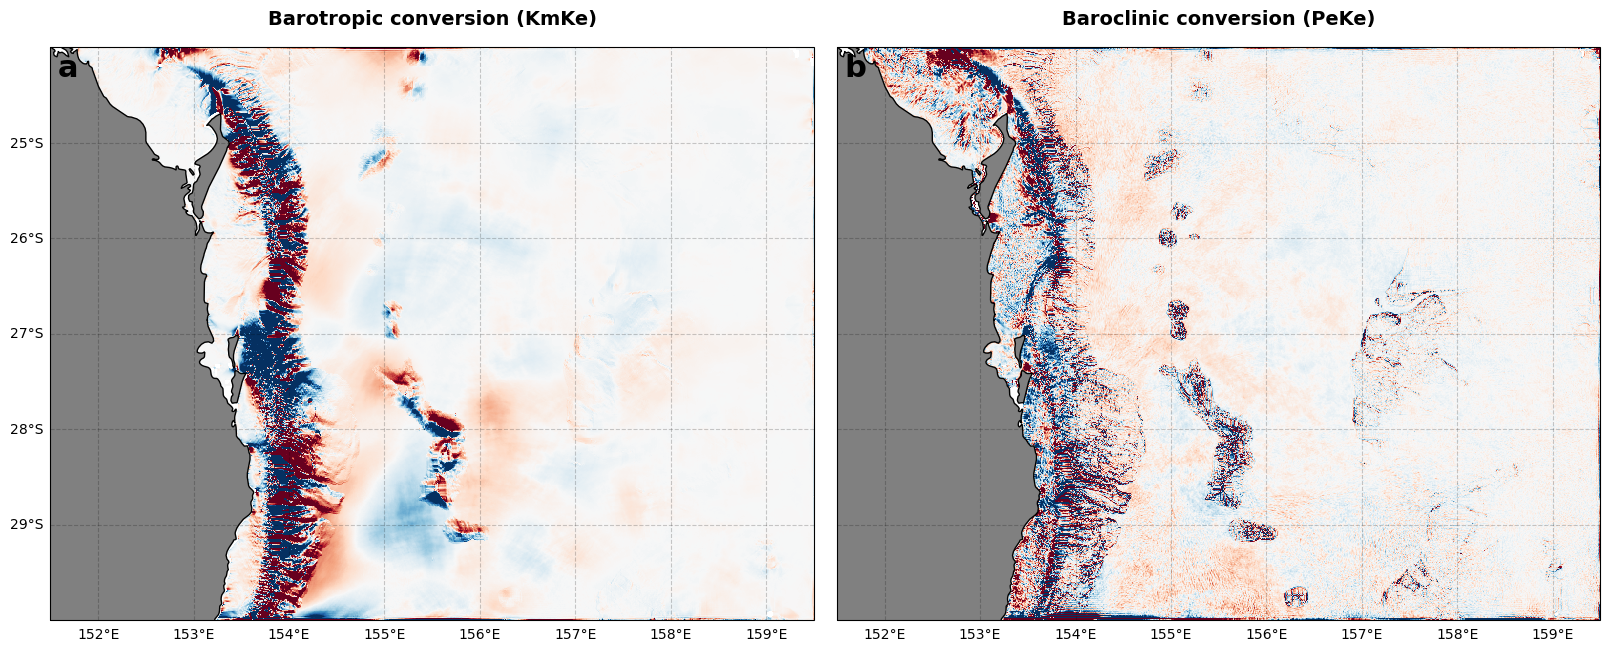

In [18]:
gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.03, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8])
ax = None

Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = ds._kmke450.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.0002,vmax=.0002)
ax.set_extent([151.5, 159.5, -30, -24])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.bottom_labels = False
ax.text(0.5, 1.05, 'Barotropic conversion (KmKe)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')



ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = ds._peke450.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.0002,vmax=.0002)
ax.set_extent([151.5, 159.5, -30, -24])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# gl.bottom_labels = False
ax.text(0.5, 1.05, 'Baroclinic conversion (PeKe)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

#cbar = fig.colorbar(im) 
#cbar.set_label('Energy conversion ($W/m^3$)',fontsize=14)